In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from itertools import product
import random

In [3]:
pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [4]:
credit = pd.read_csv('./uci_credit_card.csv')

In [5]:
X = credit.loc[:, 'LIMIT_BAL':'PAY_AMT6']
X = pd.get_dummies(X, columns=['SEX', 'EDUCATION', 'MARRIAGE'], drop_first=True)
y = credit['default.payment.next.month']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    stratify=y,
                                                    random_state=1111)

# Introducing Random Search

## Randomly samply hyperparameters

In [18]:
# Create a list of values for the learning_rate hyperparameter
learn_rate_list = list(np.linspace(0.01,1.5,200))

# Create a list of values for the min_samples_leaf hyperparameter
min_samples_list = list(range(10,41))

# Combination list
combinations_list = [list(x) for x in product(learn_rate_list, min_samples_list)]

# Sample hyperparameter combinations for a random search.
random_combinations_index = np.random.choice(range(0, len(combinations_list)), 250, replace=False)
combinations_random_chosen = [combinations_list[x] for x in random_combinations_index]

# Print the result
print(combinations_random_chosen[:5])

[[0.30201005025125627, 33], [0.09984924623115578, 19], [0.017487437185929648, 39], [1.3203015075376885, 10], [1.050753768844221, 28]]


## Randomly search with Random Forest

In [15]:
# Create lists for criterion and max_features
criterion_list = ['gini', 'entropy']
max_feature_list = ['auto', 'sqrt', 'log2', None]

# Create a list of values for the max_depth hyperparameter
max_depth_list = list(range(3,56))

# Combination list
combinations_list = [list(x) for x in product(criterion_list, max_feature_list, max_depth_list)]

# Sample hyperparameter combinations for a random search
combinations_random_chosen = random.sample(combinations_list, 150)

# Print the result
print(combinations_random_chosen[:5])

[['gini', 'auto', 32], ['gini', 'log2', 53], ['entropy', 'sqrt', 43], ['entropy', 'sqrt', 3], ['gini', None, 6]]


## Visualizing a Random Search

In [124]:
def sample_and_visualize_hyperparameters(combinations_list, n_samples):

    # If asking for all combinations, just return the entire list.
    if n_samples == len(combinations_list):
        combinations_random_chosen = combinations_list
    else:
        combinations_random_chosen = []
        random_combinations_index = np.random.choice(range(0, len(combinations_list)), n_samples, replace=False)
        combinations_random_chosen = [combinations_list[x] for x in random_combinations_index]
    
    # Pull out the X and Y to plot
    rand_x, rand_y = [x[0] for x in combinations_random_chosen], [x[1] for x in combinations_random_chosen]

    # Plot 
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(rand_x, rand_y, c=['blue']*len(combinations_random_chosen))
    ax.set(xlabel='learn_rate', 
           ylabel='min_samples_leaf', 
           title='Random Search Hyperparameters',
           xlim=(combinations_list[0][0], combinations_list[-1][0]),
           ylim=(combinations_list[0][1], combinations_list[-1][1]))
#            ylim=(combinations_list[1][0], combinations_list[1][-1]))
#     ax.set_xlim(combinations_list[0][0], combinations_list[0][-1])
#     ax.set_ylim(y_lims)
    plt.show()

In [125]:
# Create a list of values for the learning_rate hyperparameter
learn_rate_list = list(np.linspace(0.01,1.5,200))

# Create a list of values for the min_samples_leaf hyperparameter
min_samples_list = list(range(10,30))

# Combination list
combinations_list = [list(x) for x in product(learn_rate_list, min_samples_list)]

# Sample hyperparameter combinations for a random search.
random_combinations_index = np.random.choice(range(0, len(combinations_list)), 250, replace=False)
combinations_random_chosen = [combinations_list[x] for x in random_combinations_index]

# Print the result
print(combinations_random_chosen[:5])

[[0.8560804020100502, 11], [0.5191457286432161, 20], [1.4026633165829145, 22], [1.1181407035175879, 17], [1.4775376884422111, 18]]


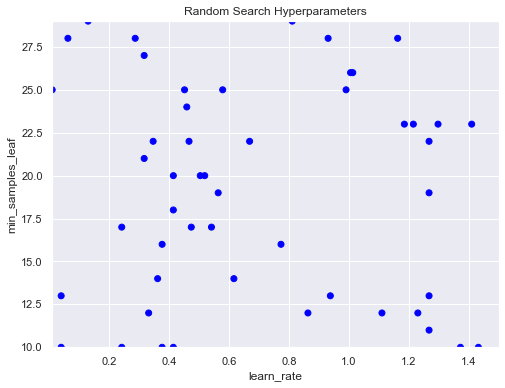

In [126]:
sample_and_visualize_hyperparameters(combinations_list, 50)

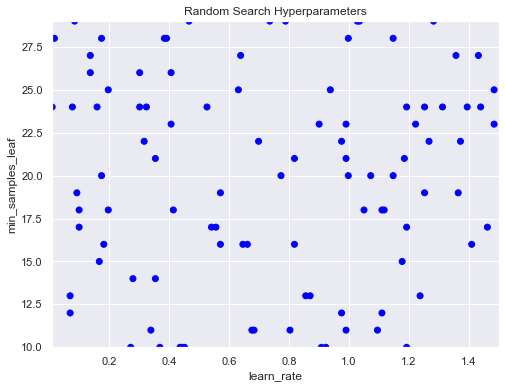

In [127]:
sample_and_visualize_hyperparameters(combinations_list, 100)

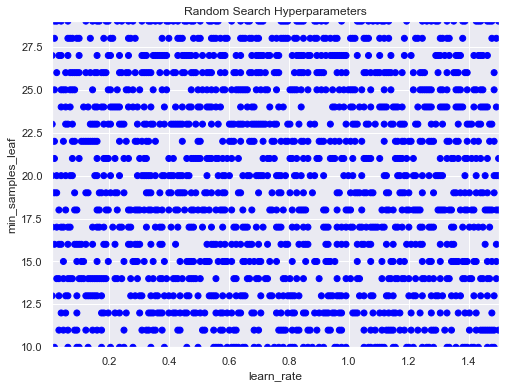

In [128]:
sample_and_visualize_hyperparameters(combinations_list, 1500)

# Random Search in `sklearn`

## The `RandomizedSearchCV` object

In [132]:
# Create the parameter grid
param_grid = {'learning_rate': np.linspace(0.1,2,150), 
              'min_samples_leaf': list(range(20,65))} 

# Create a random search object
random_GBM_class = RandomizedSearchCV(estimator=GradientBoostingClassifier(),
                                      param_distributions=param_grid,
                                      n_iter=10,
                                      scoring='accuracy', 
                                      n_jobs=-1, 
                                      cv=5, 
                                      refit=True)

# Fit to the training data
random_GBM_class.fit(X_train, y_train)

# Print the values used for both hyperparameters
print(random_GBM_class.cv_results_['param_learning_rate'])
print(random_GBM_class.cv_results_['param_min_samples_leaf'])

[1.834228187919463 0.7248322147651006 0.43154362416107384
 0.5208053691275167 1.7067114093959732 0.7248322147651006
 1.6812080536912752 1.7067114093959732 1.5536912751677854
 0.5973154362416108]
[33 61 48 30 48 63 43 44 37 31]


## `RandomizedSearchCV` in `sklearn`

In [133]:
# Create the parameter grid
param_grid = {'max_depth': list(range(5,26)), 'max_features': ['auto' , 'sqrt']} 

# Create a random search object
random_rf_class = RandomizedSearchCV(estimator=RandomForestClassifier(n_estimators=80),
                                     param_distributions=param_grid, 
                                     n_iter=5,
                                     scoring='roc_auc', 
                                     n_jobs=-1, 
                                     cv=3, 
                                     refit=True)

# Fit to the training data
random_rf_class.fit(X_train, y_train)

# Print the values used for both hyperparameters
print(random_rf_class.cv_results_['param_max_depth'])
print(random_rf_class.cv_results_['param_max_features'])

[20 13 17 19 5]
['sqrt' 'sqrt' 'auto' 'auto' 'auto']


# Comparing Grid and Random Search

In [134]:
# Create a list of values for the learning_rate hyperparameter
learn_rate_list = list(np.linspace(0.01,3.0,200))

# Create a list of values for the min_samples_leaf hyperparameter
min_samples_list = list(range(5,25))

# Combination list
combinations_list = [list(x) for x in product(learn_rate_list, min_samples_list)]

In [143]:
def visualize_search(grid_combinations_chosen, random_combinations_chosen):
    grid_y, grid_x = [x[0] for x in grid_combinations_chosen], [x[1] for x in grid_combinations_chosen]
    rand_y, rand_x = [x[0] for x in random_combinations_chosen], [x[1] for x in random_combinations_chosen]

    # Plot all together
    plt.scatter(grid_y + rand_y, grid_x + rand_x, c=['red']*300 + ['blue']*300)
    plt.gca().set(xlabel='learn_rate', ylabel='min_samples_leaf', title='Grid and Random Search Hyperparameters')
    plt.show()

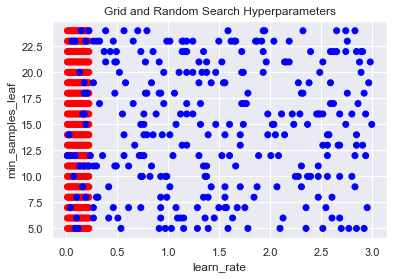

In [144]:
# Sample grid coordinates
grid_combinations_chosen = combinations_list[0:300]

# Create a list of sample indexes
sample_indexes = list(range(0,len(combinations_list)))

# Randomly sample 300 indexes
random_indexes = np.random.choice(sample_indexes, 300, replace=False)

# Use indexes to create random sample
random_combinations_chosen = [combinations_list[index] for index in random_indexes]

# Call the function to produce the visualization
visualize_search(grid_combinations_chosen, random_combinations_chosen)

You can really see how a grid search will cover a small area completely whilst random search will cover a much larger area but not completely.